<a href="https://colab.research.google.com/github/OfRoses/Masters-Degree-Vision-Transformer-for-Planting-Failure/blob/main/Mater's_Degree_Vision_Transformer_for_Planting_Failure_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
# Limpar metadados de widgets quebrados de um notebook no Colab

import nbformat
from google.colab import files

# Passo 1: Faça upload do notebook problemático
uploaded = files.upload()  # Vai abrir a janela para você selecionar o notebook (.ipynb)

# Pegamos o nome do arquivo enviado
notebook_name = list(uploaded.keys())[0]

# Passo 2: Abrir e limpar metadados de widgets
with open(notebook_name, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Remove 'metadata.widgets' se existir
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# Passo 3: Salvar um novo notebook limpo
clean_name = notebook_name.replace(".ipynb", "_limpo.ipynb")
with open(clean_name, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print(f"Notebook limpo criado: {clean_name}")

# Passo 4: Oferecer download do notebook limpo
files.download(clean_name)

IndexError: list index out of range

In [ ]:
from google.colab import drive
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torch import optim
dfrom torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
from PIL import Image
import os

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho da pasta Google Drive
image_folder_path = '/content/drive/MyDrive/classes'

# Função para mapear as imagens e rótulos
class ImageDataset(Dataset):
    def __init__(self, image_folder_path, transform=None, limit=None):
        self.image_folder_path = image_folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.limit = limit

        class_idx = 0  # Inicializa o índice da classe

        # Itera pelas subpastas para pegar as imagens e seus rótulos
        for class_name in os.listdir(image_folder_path):
            class_folder = os.path.join(image_folder_path, class_name)

            if os.path.isdir(class_folder):
                print(f"Processando classe: {class_name}")

                # Listar todas as imagens dentro da subpasta
                for image_name in os.listdir(class_folder):
                    if image_name.lower().endswith(('.jpg', '.jpeg', '.tif')):
                        self.image_paths.append(os.path.join(class_folder, image_name))
                        self.labels.append(class_idx)  # Usa o índice da classe atual
                class_idx += 1  # Incrementa o índice da classe para a próxima subpasta

        if self.limit:
            self.image_paths = self.image_paths[:self.limit]
            self.labels = self.labels[:self.limit]

        print(f"Total de imagens carregadas: {len(self.image_paths)}")

        if self.limit:
            self.image_paths = self.image_paths[:self.limit]
            self.labels = self.labels[:self.limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            # Usando o feature_extractor para transformar a imagem
            encoding = self.transform(images=image, return_tensors="pt")
            image = encoding['pixel_values'].squeeze(0)  # Remove a dimensão extra
        return image, label

# Carregar o modelo com o número correto de classes
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Defina o otimizador
optimizer = optim.Adam(model.parameters(), lr=1e-4) #aprendizado baixo

# Definir transformações
transform = feature_extractor

# Criar os datasets, dataloaders, treino e validacao
train_dataset = ImageDataset(image_folder_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

validation_dataset = ImageDataset(image_folder_path, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Função para treinar o modelo
def train_model(model, train_loader, validation_loader, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Treinamento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passar pela rede
            outputs = model(images).logits
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            # Cálculo da precisão
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            running_loss += loss.item()

        epoch_accuracy = correct_preds / total_preds
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {epoch_accuracy:.4f}")

        # Validação
        model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, preds = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

        accuracy = accuracy_score(true_labels, predicted_labels)
        precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
        print(f"Validation - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {fscore:.4f}")

        # Relatório de classificação
        print("\nRelatório de Classificação:")
        print(classification_report(true_labels, predicted_labels))

# Função para plotar a matriz de confusão
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predições")
    plt.ylabel("Verdadeiros")
    plt.show()

# Função para calcular as previsões e plotar a matriz de confusão após o treinamento
def plot_confusion_after_training(model, validation_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_true_labels = []
    all_predicted_labels = []

    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(preds.cpu().numpy())

    # Plotar a matriz de confusão
    plot_confusion_matrix(all_true_labels, all_predicted_labels, class_names)

# Defina os nomes das classes (ajuste conforme necessário)
class_names = ["Planta", "Solo", "Palha"]  # Altere isso conforme suas classes

# Chamar a função para treinar o modelo
train_model(model, train_loader, validation_loader, optimizer, epochs=10)

# Após o treinamento, gerar a matriz de confusão
plot_confusion_after_training(model, validation_loader, class_names)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Processando classe: solo
Processando classe: palha
Processando classe: planta
Total de imagens carregadas: 1885
Processando classe: solo
Processando classe: palha
Processando classe: planta
Total de imagens carregadas: 1885


Epoch 1/10: 100%|██████████| 118/118 [1:14:50<00:00, 38.06s/it]


Epoch 1 - Loss: 0.1936 - Accuracy: 0.9544
Validation - Accuracy: 0.9830 - Precision: 0.9831 - Recall: 0.9830 - F1-score: 0.9830

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       548
           1       0.98      0.98      0.98       680
           2       0.98      1.00      0.99       657

    accuracy                           0.98      1885
   macro avg       0.98      0.98      0.98      1885
weighted avg       0.98      0.98      0.98      1885



Epoch 2/10: 100%|██████████| 118/118 [1:05:25<00:00, 33.26s/it]


Epoch 2 - Loss: 0.0915 - Accuracy: 0.9767
Validation - Accuracy: 0.9889 - Precision: 0.9890 - Recall: 0.9889 - F1-score: 0.9889

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       548
           1       1.00      0.98      0.99       680
           2       0.99      1.00      0.99       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



Epoch 3/10: 100%|██████████| 118/118 [1:06:01<00:00, 33.57s/it]


Epoch 3 - Loss: 0.0546 - Accuracy: 0.9894
Validation - Accuracy: 0.9740 - Precision: 0.9751 - Recall: 0.9740 - F1-score: 0.9740

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       1.00      0.94      0.97       680
           2       0.94      1.00      0.97       657

    accuracy                           0.97      1885
   macro avg       0.98      0.98      0.97      1885
weighted avg       0.98      0.97      0.97      1885



Epoch 4/10: 100%|██████████| 118/118 [1:05:46<00:00, 33.44s/it]


Epoch 4 - Loss: 0.0728 - Accuracy: 0.9820
Validation - Accuracy: 0.9947 - Precision: 0.9947 - Recall: 0.9947 - F1-score: 0.9947

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       1.00      0.99      0.99       680
           2       1.00      1.00      1.00       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



Epoch 5/10: 100%|██████████| 118/118 [1:06:09<00:00, 33.64s/it]


Epoch 5 - Loss: 0.0470 - Accuracy: 0.9894
Validation - Accuracy: 0.9915 - Precision: 0.9916 - Recall: 0.9915 - F1-score: 0.9915

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       0.98      1.00      0.99       680
           2       1.00      0.98      0.99       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



Epoch 6/10: 100%|██████████| 118/118 [1:05:51<00:00, 33.49s/it]


Epoch 6 - Loss: 0.0365 - Accuracy: 0.9926
Validation - Accuracy: 0.9968 - Precision: 0.9968 - Recall: 0.9968 - F1-score: 0.9968

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       548
           1       1.00      1.00      1.00       680
           2       1.00      1.00      1.00       657

    accuracy                           1.00      1885
   macro avg       1.00      1.00      1.00      1885
weighted avg       1.00      1.00      1.00      1885



Epoch 7/10: 100%|██████████| 118/118 [1:05:23<00:00, 33.25s/it]


Epoch 7 - Loss: 0.0251 - Accuracy: 0.9947
Validation - Accuracy: 0.9798 - Precision: 0.9806 - Recall: 0.9798 - F1-score: 0.9798

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       548
           1       1.00      1.00      1.00       680
           2       0.95      1.00      0.97       657

    accuracy                           0.98      1885
   macro avg       0.98      0.98      0.98      1885
weighted avg       0.98      0.98      0.98      1885



Epoch 8/10: 100%|██████████| 118/118 [1:04:54<00:00, 33.00s/it]


Epoch 8 - Loss: 0.0388 - Accuracy: 0.9910
Validation - Accuracy: 0.9958 - Precision: 0.9958 - Recall: 0.9958 - F1-score: 0.9958

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       1.00      1.00      1.00       680
           2       1.00      1.00      1.00       657

    accuracy                           1.00      1885
   macro avg       1.00      1.00      1.00      1885
weighted avg       1.00      1.00      1.00      1885



Epoch 9/10:  19%|█▉        | 23/118 [12:40<52:44, 33.31s/it]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Processando classe: solo
Processando classe: palha
Processando classe: planta
Total de imagens carregadas: 1885
Processando classe: solo
Processando classe: palha
Processando classe: planta
Total de imagens carregadas: 1885


Epoch 1/1: 100%|██████████| 118/118 [1:04:55<00:00, 33.01s/it]


Epoch 1 - Loss: 0.2018 - Accuracy: 0.9576
Validation - Accuracy: 0.9321 - Precision: 0.9410 - Recall: 0.9321 - F1-score: 0.9318

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       0.99      0.83      0.90       680
           2       0.85      1.00      0.92       657

    accuracy                           0.93      1885
   macro avg       0.94      0.94      0.94      1885
weighted avg       0.94      0.93      0.93      1885



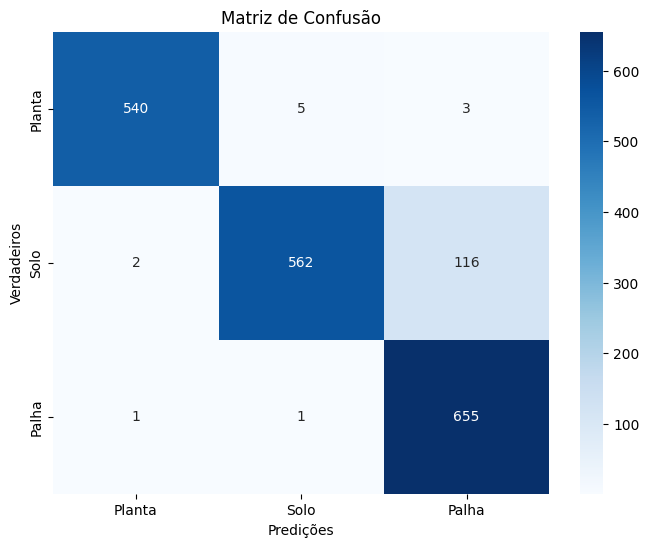

In [ ]:
from google.colab import drive
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
from PIL import Image
import os

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho da pasta Google Drive
image_folder_path = '/content/drive/MyDrive/classes'

# Função para mapear as imagens e rótulos
class ImageDataset(Dataset):
    def __init__(self, image_folder_path, transform=None, limit=None):
        self.image_folder_path = image_folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.limit = limit

        class_idx = 0  # Inicializa o índice da classe

        # Itera pelas subpastas para pegar as imagens e seus rótulos
        for class_name in os.listdir(image_folder_path):
            class_folder = os.path.join(image_folder_path, class_name)

            if os.path.isdir(class_folder):
                print(f"Processando classe: {class_name}")

                # Listar todas as imagens dentro da subpasta
                for image_name in os.listdir(class_folder):
                    if image_name.lower().endswith(('.jpg', '.jpeg', '.tif')):
                        self.image_paths.append(os.path.join(class_folder, image_name))
                        self.labels.append(class_idx)  # Usa o índice da classe atual
                class_idx += 1  # Incrementa o índice da classe para a próxima subpasta

        if self.limit:
            self.image_paths = self.image_paths[:self.limit]
            self.labels = self.labels[:self.limit]

        print(f"Total de imagens carregadas: {len(self.image_paths)}")

        if self.limit:
            self.image_paths = self.image_paths[:self.limit]
            self.labels = self.labels[:self.limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            # Usando o feature_extractor para transformar a imagem
            encoding = self.transform(images=image, return_tensors="pt")
            image = encoding['pixel_values'].squeeze(0)  # Remove a dimensão extra
        return image, label

# Carregar o modelo com o número correto de classes
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Defina o otimizador
optimizer = optim.Adam(model.parameters(), lr=1e-4) #aprendizado baixo

# Definir transformações
transform = feature_extractor

# Criar os datasets, dataloaders, treino e validacao
train_dataset = ImageDataset(image_folder_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

validation_dataset = ImageDataset(image_folder_path, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Função para treinar o modelo
def train_model(model, train_loader, validation_loader, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Treinamento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passar pela rede
            outputs = model(images).logits
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            # Cálculo da precisão
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            running_loss += loss.item()

        epoch_accuracy = correct_preds / total_preds
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {epoch_accuracy:.4f}")

        # Validação
        model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, preds = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

        accuracy = accuracy_score(true_labels, predicted_labels)
        precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
        print(f"Validation - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {fscore:.4f}")

        # Relatório de classificação
        print("\nRelatório de Classificação:")
        print(classification_report(true_labels, predicted_labels))

# Função para plotar a matriz de confusão
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predições")
    plt.ylabel("Verdadeiros")
    plt.show()

# Função para calcular as previsões e plotar a matriz de confusão após o treinamento
def plot_confusion_after_training(model, validation_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_true_labels = []
    all_predicted_labels = []

    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(preds.cpu().numpy())

    # Plotar a matriz de confusão
    plot_confusion_matrix(all_true_labels, all_predicted_labels, class_names)

# Defina os nomes das classes (ajuste conforme necessário)
class_names = ["Planta", "Solo", "Palha"]  # Altere isso conforme suas classes

# Chamar a função para treinar o modelo
train_model(model, train_loader, validation_loader, optimizer, epochs=1)

# Após o treinamento, gerar a matriz de confusão
plot_confusion_after_training(model, validation_loader, class_names)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Processando classe: solo
Processando classe: palha
Processando classe: planta
Total de imagens carregadas: 1885
Processando classe: solo
Processando classe: palha
Processando classe: planta
Total de imagens carregadas: 1885


Epoch 1/5: 100%|██████████| 118/118 [1:10:31<00:00, 35.86s/it]


Epoch 1 - Loss: 0.2018 - Accuracy: 0.9618
Validation - Accuracy: 0.9873 - Precision: 0.9873 - Recall: 0.9873 - F1-score: 0.9873

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       548
           1       0.99      0.99      0.99       680
           2       0.98      0.99      0.99       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



Epoch 2/5: 100%|██████████| 118/118 [1:04:19<00:00, 32.71s/it]


Epoch 2 - Loss: 0.0768 - Accuracy: 0.9798
Validation - Accuracy: 0.9920 - Precision: 0.9921 - Recall: 0.9920 - F1-score: 0.9920

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       0.99      1.00      0.99       680
           2       1.00      0.99      0.99       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



Epoch 3/5: 100%|██████████| 118/118 [1:04:29<00:00, 32.79s/it]


Epoch 3 - Loss: 0.0508 - Accuracy: 0.9889
Validation - Accuracy: 0.9867 - Precision: 0.9870 - Recall: 0.9867 - F1-score: 0.9868

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       548
           1       1.00      0.97      0.98       680
           2       1.00      1.00      1.00       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



Epoch 4/5: 100%|██████████| 118/118 [1:04:16<00:00, 32.68s/it]


Epoch 4 - Loss: 0.0511 - Accuracy: 0.9883
Validation - Accuracy: 0.9958 - Precision: 0.9958 - Recall: 0.9958 - F1-score: 0.9958

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       1.00      1.00      1.00       680
           2       1.00      1.00      1.00       657

    accuracy                           1.00      1885
   macro avg       1.00      1.00      1.00      1885
weighted avg       1.00      1.00      1.00      1885



Epoch 5/5: 100%|██████████| 118/118 [1:04:39<00:00, 32.88s/it]


Epoch 5 - Loss: 0.0329 - Accuracy: 0.9947
Validation - Accuracy: 0.9873 - Precision: 0.9875 - Recall: 0.9873 - F1-score: 0.9873

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       548
           1       1.00      0.97      0.99       680
           2       0.97      1.00      0.98       657

    accuracy                           0.99      1885
   macro avg       0.99      0.99      0.99      1885
weighted avg       0.99      0.99      0.99      1885



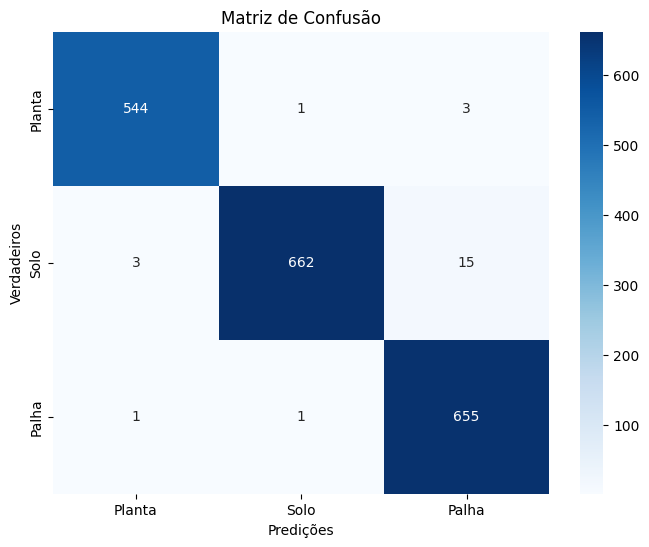

In [ ]:
from google.colab import drive
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
from PIL import Image
import os

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho da pasta Google Drive
image_folder_path = '/content/drive/MyDrive/classes'

# Função para mapear as imagens e rótulos
class ImageDataset(Dataset):
    def __init__(self, image_folder_path, transform=None, limit=None):
        self.image_folder_path = image_folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.limit = limit

        class_idx = 0  # Inicializa o índice da classe

        # Itera pelas subpastas para pegar as imagens e seus rótulos
        for class_name in os.listdir(image_folder_path):
            class_folder = os.path.join(image_folder_path, class_name)

            if os.path.isdir(class_folder):
                print(f"Processando classe: {class_name}")

                # Listar todas as imagens dentro da subpasta
                for image_name in os.listdir(class_folder):
                    if image_name.lower().endswith(('.jpg', '.jpeg', '.tif')):
                        self.image_paths.append(os.path.join(class_folder, image_name))
                        self.labels.append(class_idx)  # Usa o índice da classe atual
                class_idx += 1  # Incrementa o índice da classe para a próxima subpasta

        if self.limit:
            self.image_paths = self.image_paths[:self.limit]
            self.labels = self.labels[:self.limit]

        print(f"Total de imagens carregadas: {len(self.image_paths)}")

        if self.limit:
            self.image_paths = self.image_paths[:self.limit]
            self.labels = self.labels[:self.limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            # Usando o feature_extractor para transformar a imagem
            encoding = self.transform(images=image, return_tensors="pt")
            image = encoding['pixel_values'].squeeze(0)  # Remove a dimensão extra
        return image, label

# Carregar o modelo com o número correto de classes
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Defina o otimizador
optimizer = optim.Adam(model.parameters(), lr=1e-4) #aprendizado baixo

# Definir transformações
transform = feature_extractor

# Criar os datasets, dataloaders, treino e validacao
train_dataset = ImageDataset(image_folder_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

validation_dataset = ImageDataset(image_folder_path, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Função para treinar o modelo
def train_model(model, train_loader, validation_loader, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Treinamento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passar pela rede
            outputs = model(images).logits
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            # Cálculo da precisão
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            running_loss += loss.item()

        epoch_accuracy = correct_preds / total_preds
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {epoch_accuracy:.4f}")

        # Validação
        model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, preds = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

        accuracy = accuracy_score(true_labels, predicted_labels)
        precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
        print(f"Validation - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {fscore:.4f}")

        # Relatório de classificação
        print("\nRelatório de Classificação:")
        print(classification_report(true_labels, predicted_labels))

# Função para plotar a matriz de confusão
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predições")
    plt.ylabel("Verdadeiros")
    plt.show()

# Função para calcular as previsões e plotar a matriz de confusão após o treinamento
def plot_confusion_after_training(model, validation_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_true_labels = []
    all_predicted_labels = []

    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(preds.cpu().numpy())

    # Plotar a matriz de confusão
    plot_confusion_matrix(all_true_labels, all_predicted_labels, class_names)

# Defina os nomes das classes (ajuste conforme necessário)
class_names = ["Planta", "Solo", "Palha"]  # Altere isso conforme suas classes

# Chamar a função para treinar o modelo
train_model(model, train_loader, validation_loader, optimizer, epochs=5)

# Após o treinamento, gerar a matriz de confusão
plot_confusion_after_training(model, validation_loader, class_names)

In [ ]:
from google.colab import drive
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import os
import torch

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho para o modelo salvo
model_save_path_v2 = "/content/drive/MyDrive/visiontransformer"

# Carregar o modelo e o feature extractor
model = ViTForImageClassification.from_pretrained(model_save_path_v2)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_save_path_v2)

# Caminho da pasta com as imagens para inferência
image_folder_path = "/content/drive/MyDrive/classes100/teste"  # Substitua pelo seu caminho

# Pasta de saída para imagens modificadas
output_folder = "/content/drive/MyDrive/classes100/saida"
os.makedirs(output_folder, exist_ok=True)

# Nomes das classes
class_names = ["Solo", "Palha", "Planta"]  # Ajuste conforme seu modelo

# Função para classificar uma imagem e aplicar overlay se necessário
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs).logits
    predicted_class_idx = outputs.argmax(-1).item()
    predicted_class_name = class_names[predicted_class_idx]

    # Aplicar sobreposição vermelha se for Solo ou Palha
    if predicted_class_name in ["Solo", "Palha"]:
        red_overlay = Image.new("RGB", image.size, (255, 0, 0))
        image = Image.blend(image, red_overlay, alpha=0.4)  # Transparência ajustável

    # Salvar imagem modificada
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    image.save(output_path)

    return predicted_class_name

# Classificar todas as imagens da pasta
for image_name in os.listdir(image_folder_path):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
        image_path = os.path.join(image_folder_path, image_name)
        predicted_class = classify_image(image_path)
        print(f"Imagem: {image_name}, Classe Predita: {predicted_class}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imagem: palha1.tif, Classe Predita: Palha
Imagem: palha2.tif, Classe Predita: Palha
Imagem: planta1.tif, Classe Predita: Planta
Imagem: planta2.tif, Classe Predita: Planta
Imagem: planta3.tif, Classe Predita: Planta
Imagem: planta9.tif, Classe Predita: Planta
Imagem: planta8.tif, Classe Predita: Planta
Imagem: planta7.tif, Classe Predita: Planta
Imagem: planta6.tif, Classe Predita: Planta
Imagem: planta4.tif, Classe Predita: Planta


In [ ]:
from google.colab import drive
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import os
import torch

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho para o modelo salvo
model_save_path_v2 = "/content/drive/MyDrive/visiontransformer"

# Carregar o modelo e o feature extractor
model = ViTForImageClassification.from_pretrained(model_save_path_v2)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_save_path_v2)

# Caminho da pasta com as imagens para inferência
image_folder_path = "/content/drive/MyDrive/testeia/corte/split"

# Pasta de saída para imagens modificadas
output_folder = "/content/drive/MyDrive/testeia/corte/saida"
os.makedirs(output_folder, exist_ok=True)

# Nomes das classes
class_names = ["Solo", "Palha", "Planta"]

# Função para classificar uma imagem e salvar com ou sem overlay
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs).logits
    predicted_class_idx = outputs.argmax(-1).item()
    predicted_class_name = class_names[predicted_class_idx]

    # Se for Solo ou Palha, aplicar overlay vermelho
    if predicted_class_name in ["Solo", "Palha"]:
        red_overlay = Image.new("RGB", image.size, (255, 0, 0))
        image = Image.blend(image, red_overlay, alpha=0.4)

    # Salvar a imagem (modificada ou não)
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    image.save(output_path)

    return predicted_class_name

# Classificar e salvar todas as imagens
for image_name in os.listdir(image_folder_path):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
        image_path = os.path.join(image_folder_path, image_name)
        predicted_class = classify_image(image_path)
        print(f"Imagem: {image_name}, Classe Predita: {predicted_class}")


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Imagem: imagem_3885_1400.tif, Classe Predita: Palha
Imagem: imagem_3850_1890.tif, Classe Predita: Solo
Imagem: imagem_3745_2415.tif, Classe Predita: Palha
Imagem: imagem_3990_2030.tif, Classe Predita: Planta
Imagem: imagem_3885_1960.tif, Classe Predita: Palha
Imagem: imagem_3920_1120.tif, Classe Predita: Palha
Imagem: imagem_3955_1925.tif, Classe Predita: Palha
Imagem: imagem_3745_1575.tif, Classe Predita: Palha
Imagem: imagem_3745_1190.tif, Classe Predita: Planta
Imagem: imagem_3885_2205.tif, Classe Predita: Planta
Imagem: imagem_3990_2380.tif, Classe Predita: Palha
Imagem: imagem_3955_2030.tif, Classe Predita: Palha
Imagem: imagem_3780_2450.tif, Classe Predita: Planta
Imagem: imagem_3815_1190.tif, Classe Predita: Palha
Imagem: imagem_3955_2100.tif, Classe Predita: Planta
Imagem: imagem_3885_2345.tif, Classe Predita: Planta
Imagem: imagem_3885_1435.tif, Classe Predita: Planta
Imagem: imagem_4025_1995.tif, Classe Predita: Palha
Imagem: imagem_3815_1715.tif, Classe Predita: Planta
Image

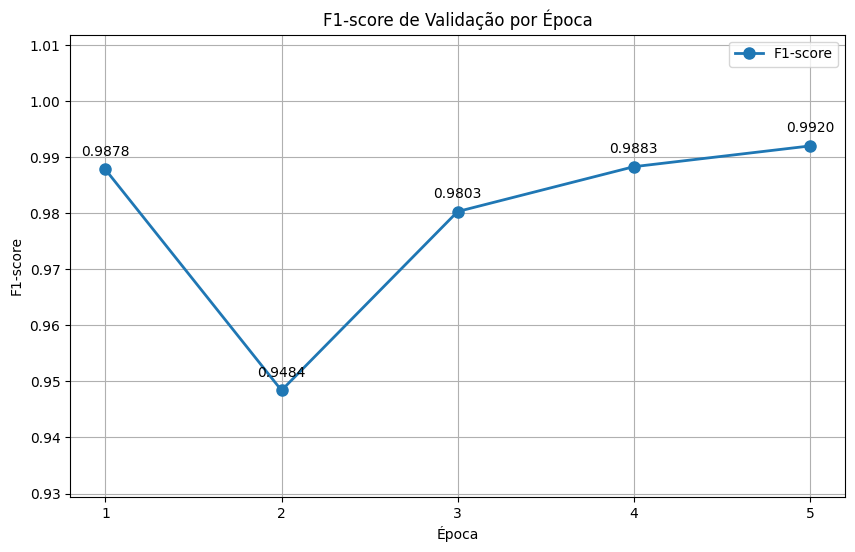

In [ ]:
import matplotlib.pyplot as plt

# Data extracted for F1-score validation metric per epoch
epochs = range(1, 6)
f1_score_values = [0.9878, 0.9484, 0.9803, 0.9883, 0.9920]

# --- Gráfico para F1-score ---
plt.figure(figsize=(10, 6))
metric_name = 'F1-score'
values = f1_score_values # Usando a lista específica de F1-score

# Plotar com linha e marcadores mais visíveis
plt.plot(epochs, values, marker='o', linestyle='-', label=metric_name, linewidth=2, markersize=8)

# Adicionar anotações
for i, value in enumerate(values):
    plt.annotate(f'{value:.4f}',
                 (epochs[i], values[i]),
                 textcoords="offset points",
                 xytext=(0, 10), # Deslocamento vertical do texto
                 ha='center')    # Alinhamento horizontal

plt.title(f'{metric_name} de Validação por Época')
plt.xlabel('Época')
plt.ylabel(metric_name)
plt.xticks(epochs)
# Ajustar limite Y dinamicamente, garantindo que os pontos estejam visíveis
plt.ylim(min(values) * 0.98, max(values) * 1.02)
plt.grid(True)
plt.legend() # Adicionar legenda para identificar a linha
plt.show()

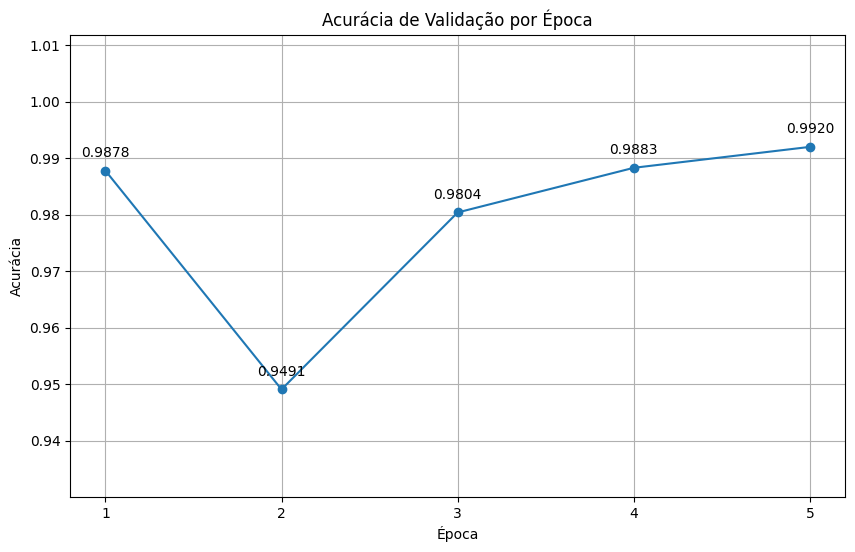

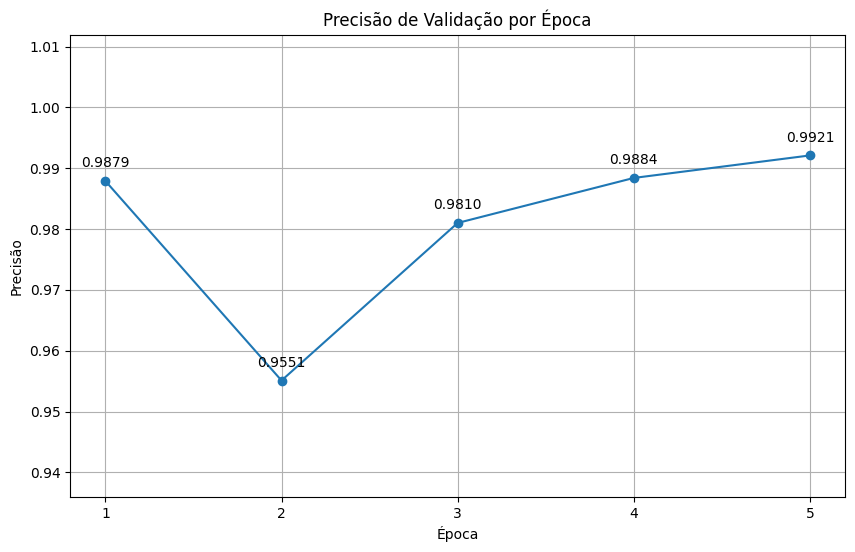

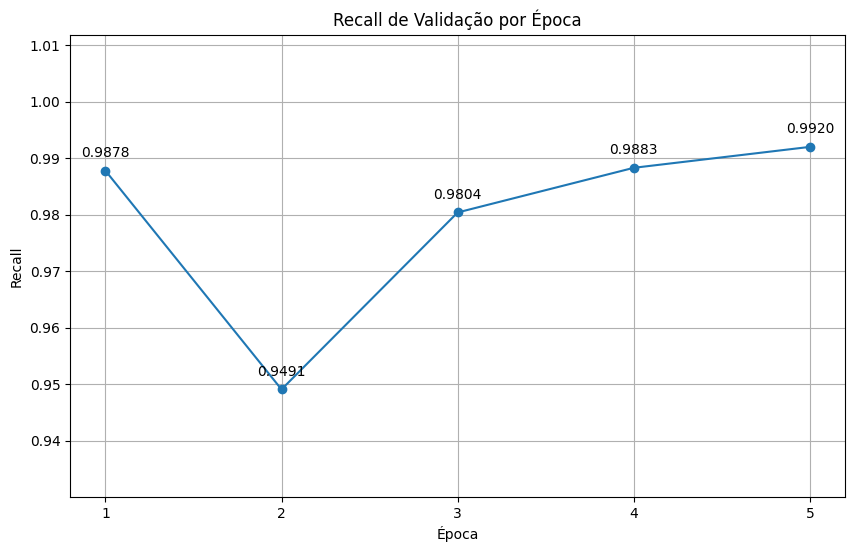

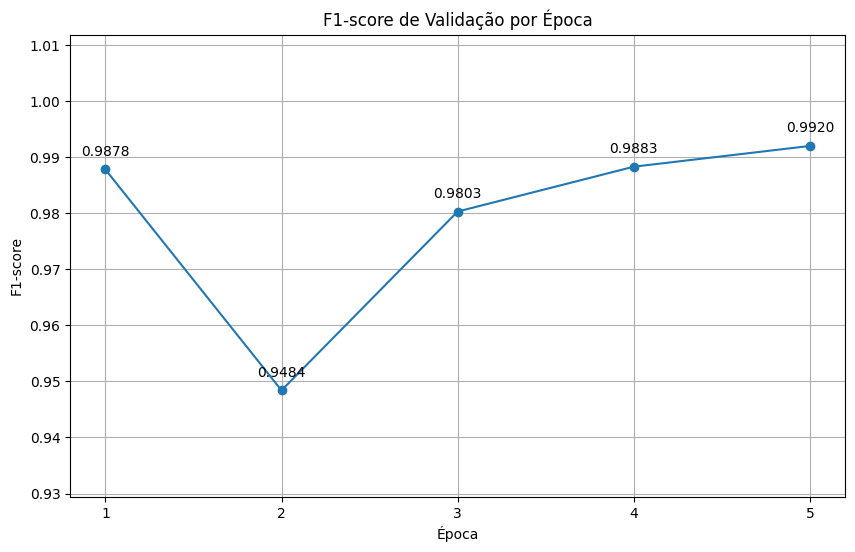

In [ ]:
import matplotlib.pyplot as plt

# Data extracted from the validation metrics per epoch
epochs = range(1, 6)

validation_metrics = {
    'Acurácia': [0.9878, 0.9491, 0.9804, 0.9883, 0.9920],
    'Precisão': [0.9879, 0.9551, 0.9810, 0.9884, 0.9921],
    'Recall': [0.9878, 0.9491, 0.9804, 0.9883, 0.9920],
    'F1-score': [0.9878, 0.9484, 0.9803, 0.9883, 0.9920]
}

# --- Gráfico para Acurácia ---
plt.figure(figsize=(10, 6))
metric_name = 'Acurácia'
values = validation_metrics[metric_name]
plt.plot(epochs, values, marker='o', linestyle='-')

# Adicionar anotações
for i, value in enumerate(values):
    plt.annotate(f'{value:.4f}', (epochs[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title(f'{metric_name} de Validação por Época')
plt.xlabel('Época')
plt.ylabel(metric_name)
plt.xticks(epochs)
plt.ylim(min(values) * 0.98, max(values) * 1.02) # Ajustar limite Y dinamicamente
plt.grid(True)
plt.show()

# --- Gráfico para Precisão ---
plt.figure(figsize=(10, 6))
metric_name = 'Precisão'
values = validation_metrics[metric_name]
plt.plot(epochs, values, marker='o', linestyle='-')

# Adicionar anotações
for i, value in enumerate(values):
    plt.annotate(f'{value:.4f}', (epochs[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title(f'{metric_name} de Validação por Época')
plt.xlabel('Época')
plt.ylabel(metric_name)
plt.xticks(epochs)
plt.ylim(min(values) * 0.98, max(values) * 1.02) # Ajustar limite Y dinamicamente
plt.grid(True)
plt.show()

# --- Gráfico para Recall ---
plt.figure(figsize=(10, 6))
metric_name = 'Recall'
values = validation_metrics[metric_name]
plt.plot(epochs, values, marker='o', linestyle='-')

# Adicionar anotações
for i, value in enumerate(values):
    plt.annotate(f'{value:.4f}', (epochs[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title(f'{metric_name} de Validação por Época')
plt.xlabel('Época')
plt.ylabel(metric_name)
plt.xticks(epochs)
plt.ylim(min(values) * 0.98, max(values) * 1.02) # Ajustar limite Y dinamicamente
plt.grid(True)
plt.show()

# --- Gráfico para F1-score ---
plt.figure(figsize=(10, 6))
metric_name = 'F1-score'
values = validation_metrics[metric_name]
plt.plot(epochs, values, marker='o', linestyle='-')

# Adicionar anotações
for i, value in enumerate(values):
    plt.annotate(f'{value:.4f}', (epochs[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title(f'{metric_name} de Validação por Época')
plt.xlabel('Época')
plt.ylabel(metric_name)
plt.xticks(epochs)
plt.ylim(min(values) * 0.98, max(values) * 1.02) # Ajustar limite Y dinamicamente
plt.grid(True)
plt.show()